# Instalacja wymaganych bibliotek

In [ ]:
import sys
!{sys.executable} -m pip install tqdm # progress bar
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install matplotlib

# Dane do testowania (2 zbiory)

Oryginalnie pobrane z:  
- https://www.kaggle.com/frederikklement/germantrees  
- https://www.kaggle.com/phylake1337/fire-dataset  


[Dane do pobrania z GDrive](https://drive.google.com/drive/folders/1H4guzt-gIQrWQdNJDyl6AVtybTdtd2UK?usp=sharing) (Nie trzeba konta na kaggle)  
Pobrane dane należy umieścić w folderze z notebookiem (w swoich folderach)  
Można pomyśleć nad tym żeby z tych danych jeszcze np. wydzielić tylko te czerwieńsze pożary ?  
Może wtedy będzie bardziej jaskrawe płomienie kolorować ?

# Import wymaganych bibliotek

In [143]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, UpSampling2D,  Conv2D, Dense, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from random import shuffle
import os
import skimage as sk
from skimage.color import rgb2lab, lab2rgb
from matplotlib import pyplot as plt

# Deklaracja modelu autoenkodera

In [131]:
class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__(name='encoder')

        self.layer_1 = InputLayer((256, 256, 1,))
        self.layer_2 = Conv2D(256, (3, 3), activation='relu', padding='same', strides=(2, 2))
        self.layer_3 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.layer_4 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))
        self.layer_5 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.layer_6 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))
        self.layer_7 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.layer_8 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.layer_9 = Conv2D(16, (3, 3), activation='relu', padding='same')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = self.layer_6(x)
        x = self.layer_7(x)
        x = self.layer_8(x)
        x = self.layer_9(x)
        return x

class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__(name='decoder')

        self.layer_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.layer_2 = UpSampling2D((2, 2))
        self.layer_3 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.layer_4 = UpSampling2D((2, 2))
        self.layer_5 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.layer_6 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.layer_7 = Conv2D(2, (3, 3), activation='tanh', padding='same')
        self.layer_8 = UpSampling2D((2, 2))

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = self.layer_6(x)
        x = self.layer_7(x)
        x = self.layer_8(x)
        return x
    
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__(name='autoencoder')

        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

# Przygotowywanie i ładowanie danych

In [132]:
SIZE = 256
color_img = []
# Można też tutaj dać ./leaves
path = './fire_images'
files = os.listdir(path)
print("Found {} images.".format(len(files)))
color_img = []
gray_img = []

for f in tqdm(files):
    img = plt.imread(path + '/' + f, format='jpg')
    img = sk.transform.resize(img, (SIZE, SIZE, 3))
    img = sk.img_as_float32(img)
    lab = rgb2lab(img)
    gray_img.append(lab[:,:,0])
    color_img.append(lab[:,:,1:] / 128)
    
color_img = np.array(color_img)
gray_img = np.array(gray_img)

gray_img = gray_img.reshape(gray_img.shape +(1,))
print("Grayscale data shape: {}".format(gray_img.shape))
print("Colored data shape: {}".format(color_img.shape))
#     color_img.append(img)
#     gray_img.append(sk.color.rgb2gray(img))
#     plot_images(color_img[-1], gray_img[-1])

755



 21%|████████████████▋                                                               | 158/755 [00:12<00:32, 18.18it/s]


 41%|█████████████████████████████████                                               | 312/755 [00:41<00:50,  8.75it/s]


 58%|██████████████████████████████████████████████▌                                 | 439/755 [01:30<02:05,  2.52it/s]


 75%|████████████████████████████████████████████████████████████▍                   | 570/755 [02:10<00:46,  3.96it/s]


 94%|███████████████████████████████████████████████████████████████████████████▍    | 712/755 [02:38<00:03, 10.75it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 755/755 [02:44<00:00,  4.60it/s]


(755, 256, 256, 1)
(755, 256, 256, 2)


# Uczenie modelu

In [135]:
# TEST_SIZE = 800

# train_gray = gray_img[:TEST_SIZE]
# train_color = color_img[:TEST_SIZE]
# test_gray = gray_img[TEST_SIZE:]
# test_color = color_img[TEST_SIZE:]

# train_g = np.reshape(train_gray, (len(train_gray), SIZE, SIZE, 1))
# train_c = np.reshape(train_color, (len(train_color), SIZE, SIZE, 3))
# test_g = np.reshape(test_gray, (len(test_gray), SIZE, SIZE, 1))
# test_c = np.reshape(test_color, (len(test_color), SIZE, SIZE, 3))

model = Autoencoder()
model.compile(optimizer=Adam(),
              loss='mean_squared_error',
              metrics=['accuracy'])
# Dla uczenia dla np. 10 epok daje nieco lepsze wyniki ale uczy się znacznie dłużej
model.fit(gray_img, color_img, batch_size=32, epochs=1, validation_split=0.2)

(256, 256, 1) (256, 256, 2)
Train on 604 samples, validate on 151 samples
Epoch 1/10
604/604 [==============================] - ETA: 6:30 - loss: 0.0486 - accuracy: 0.59 - ETA: 6:03 - loss: 0.0434 - accuracy: 0.55 - ETA: 5:39 - loss: 0.0379 - accuracy: 0.55 - ETA: 5:16 - loss: 0.0332 - accuracy: 0.56 - ETA: 4:54 - loss: 0.0464 - accuracy: 0.55 - ETA: 4:32 - loss: 0.0444 - accuracy: 0.57 - ETA: 4:11 - loss: 0.0439 - accuracy: 0.57 - ETA: 3:50 - loss: 0.0439 - accuracy: 0.55 - ETA: 3:30 - loss: 0.0445 - accuracy: 0.55 - ETA: 3:09 - loss: 0.0434 - accuracy: 0.56 - ETA: 2:47 - loss: 0.0427 - accuracy: 0.57 - ETA: 2:25 - loss: 0.0421 - accuracy: 0.57 - ETA: 2:04 - loss: 0.0424 - accuracy: 0.57 - ETA: 1:43 - loss: 0.0409 - accuracy: 0.58 - ETA: 1:21 - loss: 0.0398 - accuracy: 0.58 - ETA: 1:00 - loss: 0.0392 - accuracy: 0.58 - ETA: 39s - loss: 0.0385 - accuracy: 0.5918 - ETA: 18s - loss: 0.0382 - accuracy: 0.592 - 439s 726ms/sample - loss: 0.0378 - accuracy: 0.5920 - val_loss: 0.0215 - val_ac

604/604 [==============================] - ETA: 6:04 - loss: 0.0208 - accuracy: 0.60 - ETA: 5:45 - loss: 0.0224 - accuracy: 0.62 - ETA: 5:25 - loss: 0.0209 - accuracy: 0.64 - ETA: 5:04 - loss: 0.0206 - accuracy: 0.65 - ETA: 4:44 - loss: 0.0208 - accuracy: 0.65 - ETA: 4:23 - loss: 0.0212 - accuracy: 0.65 - ETA: 4:03 - loss: 0.0224 - accuracy: 0.65 - ETA: 3:42 - loss: 0.0219 - accuracy: 0.64 - ETA: 3:22 - loss: 0.0216 - accuracy: 0.64 - ETA: 3:01 - loss: 0.0216 - accuracy: 0.64 - ETA: 2:41 - loss: 0.0233 - accuracy: 0.64 - ETA: 2:20 - loss: 0.0231 - accuracy: 0.64 - ETA: 2:00 - loss: 0.0228 - accuracy: 0.64 - ETA: 1:39 - loss: 0.0225 - accuracy: 0.64 - ETA: 1:19 - loss: 0.0223 - accuracy: 0.64 - ETA: 58s - loss: 0.0222 - accuracy: 0.6446 - ETA: 38s - loss: 0.0221 - accuracy: 0.644 - ETA: 17s - loss: 0.0220 - accuracy: 0.645 - 426s 705ms/sample - loss: 0.0225 - accuracy: 0.6461 - val_loss: 0.0183 - val_accuracy: 0.6672
Epoch 10/10
604/604 [==============================] - ETA: 6:06 - los

# Sprawdzanie wyników uczenia

None
(20, 256, 256, 1)


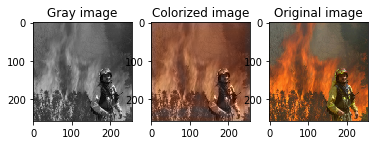

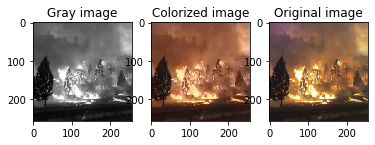

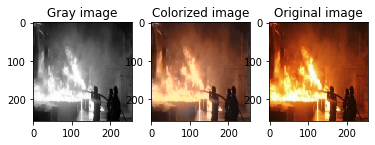

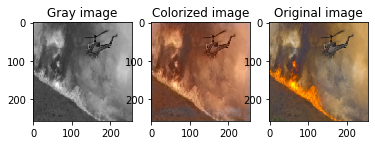

D:\Programy\Anaconda\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 207 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


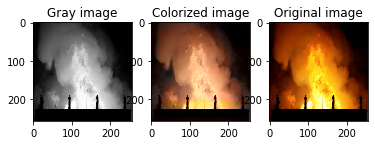

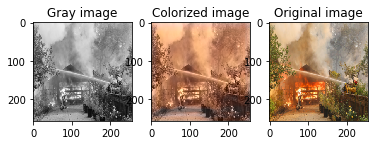

D:\Programy\Anaconda\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 78 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


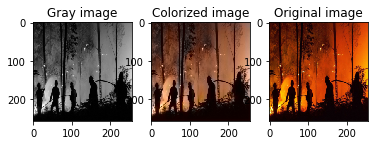

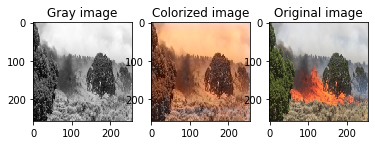

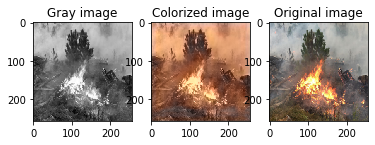

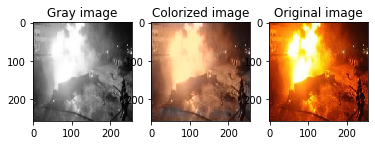

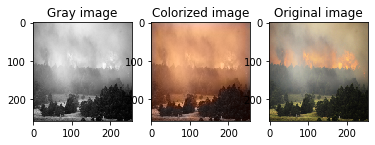

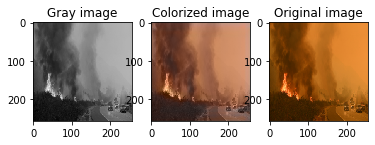

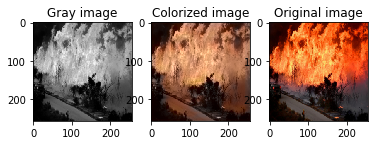

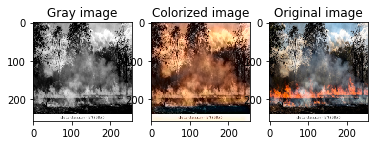

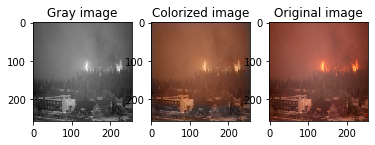

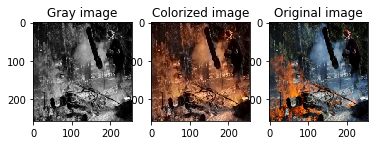

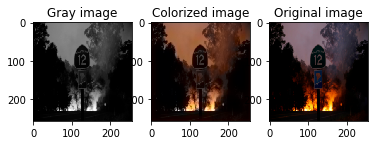

D:\Programy\Anaconda\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


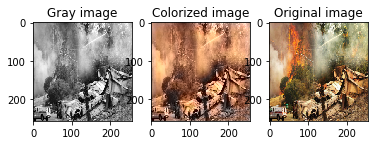

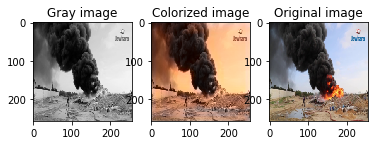

D:\Programy\Anaconda\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


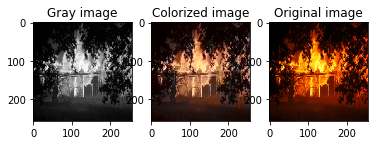

In [147]:
to_color = []
true = []
shuffle(files)
for test in files[:20]:
    img = plt.imread(path+'/'+test, format='jpg')
    img = sk.transform.resize(img, (SIZE, SIZE, 3))
    img = sk.img_as_float32(img)
    to_color.append(img)
    true = to_color[:]
to_color = np.array(to_color, dtype=float)
to_color = rgb2lab(to_color)[:,:,:,0]
to_color = to_color.reshape(to_color.shape+(1,))
print(to_color.shape)

a = model.predict(to_color)
a = a * 128

for i in range(len(a)):
    plt.subplot(131)
    plt.imshow(np.squeeze(to_color[i]), cmap="gray")
    plt.title("Gray image")
    
    result = np.zeros((256, 256, 3))
    result[:,:,0] = to_color[i][:,:,0]
    result[:,:,1:] = a[i]
    plt.subplot(132)
    plt.imshow(lab2rgb(result))
    plt.title("Colorized image")
    
    plt.subplot(133)
    plt.imshow(true[i])
    plt.title("Original image")
    plt.show()